In [1]:
import nibabel as nib
import pandas as pd
import numpy as np
import os
import glob
import scipy.io as sio
import torch
from torch.utils.data import TensorDataset, DataLoader
from huggingface_hub import hf_hub_download
from fMRIVAE_Model import BetaVAE
import matplotlib.pyplot as plt

/data/wheelock/data1/people/Chenyan/Tu-2025-VAE_FC_embedding/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cifti2_filename(cifti1_path, output_dir):
    basename = os.path.basename(cifti1_path)

    # List of known CIFTI suffixes
    known_suffixes = [".dtseries.nii", ".dconn.nii", ".dscalar.nii", ".dpconn.nii"]

    # Match and strip full suffix
    for suffix in known_suffixes:
        if basename.endswith(suffix):
            stem = basename[: -len(suffix)]  # strip the full suffix
            cifti2_name = f"{stem}_cifti2{suffix}"
            return os.path.join(output_dir, cifti2_name)

    raise ValueError("Unknown CIFTI suffix in filename")

In [3]:
def retrieve_filepath(dataset_folder, subj, suffix):
    """
    Retrieve the path of a file in `dataset_folder` that contains `subj` and ends with `suffix`.
    
    Parameters:
        dataset_folder (str): Path to the dataset folder.
        subj (str): Substring that must be contained in the filename.
        suffix (str): File ending (e.g., '.nii', '_bold.dtseries.nii').
    
    Returns:
        str: Full path to the matching file.
    
    Raises:
        FileNotFoundError: If no matching file is found.
        RuntimeError: If multiple matching files are found.
    """
    pattern = os.path.join(dataset_folder, f"*{subj}*{suffix}")
    matched_files = glob.glob(pattern)

    if len(matched_files) == 0:
        raise FileNotFoundError(f"No file found for subject '{subj}' ending with '{suffix}' in '{dataset_folder}'.")
    elif len(matched_files) > 1:
        raise RuntimeError(f"Multiple files found for subject '{subj}' ending with '{suffix}': {matched_files}")
    
    return matched_files[0]

In [4]:
def calc_correlations(input_file, tmask):
    if input_file.endswith(".dtseries.nii"):
        cifti_img = nib.load(input_file)
        cifti_data = cifti_img.get_fdata()
        # cifti_header = cifti_img.header
        bm_index_map = cifti_img.header.get_index_map(1)

        # Initialize storage
        vertex_indices = []
        # Loop through the brain models in the index map
        for bm in bm_index_map.brain_models:
            structure = bm.brain_structure
            if structure in ['CIFTI_STRUCTURE_CORTEX_LEFT', 'CIFTI_STRUCTURE_CORTEX_RIGHT']:
                # Convert Cifti2VertexIndices to numpy array
                offset = bm.index_offset
                count = bm.index_count
                vertex_indices.extend(range(offset, offset + count))

        vertex_indices = np.array(vertex_indices)
        cortex_ts = np.transpose(cifti_data[:, vertex_indices])
        masked_cortex_ts = cortex_ts[:, tmask]
        corr_matrix = np.corrcoef(masked_cortex_ts)
        return corr_matrix
    else:
        raise ValueError("Input file must be a CIFTI-2 time-series file. ")

In [5]:
def calc_parcel_vertex_correlations(dtseries_file, ptseries_file, tmask, parcellation):
    """
    Calculates the correlation between parcellated time series (e.g., 333 regions)
    and vertex-level time series across the cortex from a CIFTI dtseries file.

    This function:
    - Loads a .ptseries.nii file (parcellated time series) and reorders it using a parcellation struct
    - Filters out networks labeled "None" or "USp"
    - Applies a temporal mask (tmask) to remove motion-contaminated frames
    - Loads a .dtseries.nii file (vertex-level BOLD time series)
    - Extracts cortical vertex data from left and right hemispheres
    - Computes Pearson correlation between each parcel and each vertex
    - Returns a matrix of shape (num_parcels_retained, num_cortical_vertices)

    Parameters
    ----------
    dtseries_file : str
        Path to the CIFTI-2 .dtseries.nii file (e.g., fsLR surface BOLD time series).
    
    ptseries_file : str
        Path to the CIFTI-2 .ptseries.nii file containing parcellated time series.
    
    tmask : ndarray of shape (timepoints,)
        Boolean array indicating timepoints to keep (True = retain).
    
    parcellation : dict
        Dictionary loaded from a MATLAB .mat file, containing keys:
        - 'order': ordering of parcel columns
        - 'key': mapping between parcels and network labels
        - 'Nets': array of network name strings
        - 'cMap': colormap used for visualization (not used here)
    
    Returns
    -------
    parcel_vertex_corr_matrix : ndarray of shape (num_parcels_retained, num_cortical_vertices)
        Pearson correlation matrix between each retained parcel and each cortical vertex.
    
    Raises
    ------
    ValueError
        If zero or multiple "None"/"USp" network labels are found in the parcellation.
    
    Notes
    -----
    - Assumes that the .ptseries and .dtseries are aligned in time and space.
    - No normalization is applied to the BOLD signals before correlation (only mean-centering).
    - Uses np.corrcoef to efficiently compute the full correlation matrix.
    """

    # --- Check file types
    assert dtseries_file.endswith(".dtseries.nii")
    assert ptseries_file.endswith("ptseries.nii")

    # --- Load parcellated time series
    ptseries_img = nib.load(ptseries_file)
    ptseries_data = ptseries_img.get_fdata()

    # --- Load parcellation metadata
    parcel_order = parcellation["order"][0, 0].flatten() - 1 # make it Python-style (starts from 0)
    parcel_keys = parcellation["key"][0, 0]
    net_names = parcellation["Nets"][0, 0].flatten()
    net_colors = parcellation["cMap"][0, 0]

    # --- Identify index to exclude: "None" or "USp"
    none_idx = [i+1 for i, val in enumerate(net_names) if val.item() in ["None", "USp"]]
    # Ensure only one match
    if len(none_idx) != 1:
        raise ValueError(f"Expected exactly one match for 'None' or 'USp', but found: {len(none_idx)}")
    none_idx = none_idx[0]
    keepnets = parcel_keys[:, 1] != none_idx

    ptseries_ordered = ptseries_data[:, parcel_order]
    ptseries_ordered = ptseries_ordered[:, keepnets]
    ptseries_masked = np.transpose(ptseries_ordered[tmask])

    dtseries_img = nib.load(dtseries_file)
    dtseries_data = dtseries_img.get_fdata()
    bm_index_map = dtseries_img.header.get_index_map(1)

    # --- Extract all cortical vertex indices
    vertex_indices = []
    # Loop through the brain models in the index map
    for bm in bm_index_map.brain_models:
        structure = bm.brain_structure
        if structure in ['CIFTI_STRUCTURE_CORTEX_LEFT', 'CIFTI_STRUCTURE_CORTEX_RIGHT']:
            # Convert Cifti2VertexIndices to numpy array
            offset = bm.index_offset
            count = bm.index_count
            vertex_indices.extend(range(offset, offset + count))

    vertex_indices = np.array(vertex_indices)
    cortex_dtseries = np.transpose(dtseries_data[:, vertex_indices])
    masked_cortex_dtseries = cortex_dtseries[:, tmask]

    # --- Compute parcel–vertex correlation matrix using np.corrcoef
    full_corr_matrix = np.corrcoef(np.vstack([ptseries_masked, masked_cortex_dtseries]))
    num_parcels = ptseries_masked.shape[0]
    parcel_vertex_corr_matrix = full_corr_matrix[:num_parcels, num_parcels:]
    return parcel_vertex_corr_matrix

In [6]:
# def forward_reformatting(corrs, transmat_path, img_size):
#     # assert corrs.shape == (59412, )
#     left_data, right_data = corrs[:29696, :], corrs[29696:, :]
#     left_mask = sio.loadmat(os.path.join(transmat_path, "Left_fMRI2Grid_192_by_192_NN.mat"))
#     right_mask = sio.loadmat(os.path.join(transmat_path, "Right_fMRI2Grid_192_by_192_NN.mat"))
#     left_transmat = left_mask['grid_mapping']
#     right_transmat = right_mask['grid_mapping']
    
#     left_surf_data = np.reshape(left_transmat @ left_data, (img_size, img_size, 1, -1), order='F')
#     left_surf_data = np.transpose(left_surf_data, axes=(3, 2, 0, 1)) # (batch, 1, height_width)
#     right_surf_data = np.reshape(right_transmat @ right_data, (img_size, img_size, 1, -1), order='F')
#     right_surf_data = np.transpose(right_surf_data, axes=(3, 2, 0, 1))

#     return left_surf_data, right_surf_data

def forward_reformatting(corrs, transmat_path, img_size):
    """
    Projects vertex-level data onto 2D cortical grids for left and right hemispheres.

    This function:
    - Splits vertex-level fMRI data into left and right hemispheres
    - Applies hemisphere-specific transformation matrices (e.g., fMRI-to-grid)
    - Reshapes the resulting 2D projection into image format for model input

    Parameters
    ----------
    corrs : ndarray of shape (num_samples, num_features)
        Vertex-level input data (e.g., correlation values or BOLD signals).
        Assumes num_features = 59412 (29696 left + 29716 right cortical vertices).
    
    transmat_path : str
        Directory path containing 'Left_fMRI2Grid_192_by_192_NN.mat' and 
        'Right_fMRI2Grid_192_by_192_NN.mat', each with a 'grid_mapping' matrix.
    
    img_size : int
        The side length of the 2D grid (e.g., 192 for a 192×192 projection).
    
    Returns
    -------
    left_surf_data : ndarray of shape (num_samples, 1, img_size, img_size)
        2D grid representation of left hemisphere data.
    
    right_surf_data : ndarray of shape (num_samples, 1, img_size, img_size)
        2D grid representation of right hemisphere data.

    Notes
    -----
    - The transformation matrices are assumed to be of shape (img_size*img_size, num_vertices).
    - Data is reshaped using column-major (Fortran-style) ordering to match MATLAB-style layouts.
    - Output is formatted in NCHW format for input to deep learning models (e.g., CNNs).
    """
    num_samples, num_vertices = corrs.shape
    assert num_vertices == 59412, "Expected 59412 cortical vertices (29696 left + 29716 right)."

    # Split input features into left and right hemispheres
    left_data = corrs[:, :29696]   # shape: (num_samples, 29696)
    right_data = corrs[:, 29696:]  # shape: (num_samples, 29716)

    # Load transformation matrices
    left_transmat = sio.loadmat(os.path.join(transmat_path, "Left_fMRI2Grid_192_by_192_NN.mat"))['grid_mapping']
    right_transmat = sio.loadmat(os.path.join(transmat_path, "Right_fMRI2Grid_192_by_192_NN.mat"))['grid_mapping']

    # Project data onto 2D grid
    left_proj = left_data @ left_transmat.T    # shape: (num_samples, img_size * img_size)
    right_proj = right_data @ right_transmat.T # shape: (num_samples, img_size * img_size)

    # Reshape to (num_samples, 1, img_size, img_size) using column-major (Fortran-style) order
    left_surf_data = np.reshape(left_proj, (num_samples, 1, img_size, img_size), order='F')
    right_surf_data = np.reshape(right_proj, (num_samples, 1, img_size, img_size), order='F')

    return left_surf_data, right_surf_data

In [7]:
def backword_reformatting(left_surf_recon, right_surf_recon, transmat_path):
    assert left_surf_recon.shape == right_surf_recon.shape
    batch_size = left_surf_recon.shape[0]
    left_mask = sio.loadmat(os.path.join(transmat_path, "Left_fMRI2Grid_192_by_192_NN.mat"))
    right_mask = sio.loadmat(os.path.join(transmat_path, "Right_fMRI2Grid_192_by_192_NN.mat"))
    left_transmat_backward = left_mask['inverse_transformation']
    right_transmat_backward = right_mask['inverse_transformation']

    left_corrs = left_transmat_backward @ left_surf_recon.reshape(batch_size, -1).T
    right_corrs = right_transmat_backward @ right_surf_recon.reshape(batch_size, -1).T
    dtseries_recon = np.vstack((left_corrs, right_corrs))
    dtseries_recon[dtseries_recon == 0] = 1
    return dtseries_recon

In [8]:
# def rand_sample(left_surf_data, right_surf_data, sample_ratio=1.0):
#     assert left_surf_data.shape == right_surf_data.shape
#     if sample_ratio <= 0 or sample_ratio > 1.0:
#         raise ValueError("Please pick a sample ratio between 0 and 1. ")
#     # print(left_surf_data.shape)
#     sample_size, _, _, img_size = left_surf_data.shape
#     indices = np.random.choice(sample_size, int(sample_size*sample_ratio), replace=False)
#     sampled_left_surf_data = left_surf_data[indices, :, :, :]
#     sampled_right_surf_data  = right_surf_data[indices, :, :, :]
#     return sampled_left_surf_data, sampled_right_surf_data

def rand_sample(corrs, sample_ratio=1.0):
    if sample_ratio <= 0 or sample_ratio > 1.0:
        raise ValueError("Please pick a sample ratio between 0 and 1. ")
    # print(left_surf_data.shape)
    sample_size = corrs.shape[1]
    indices = np.random.choice(sample_size, int(sample_size*sample_ratio), replace=False)
    sampled_corrs = corrs[:, indices]
    return sampled_corrs

In [9]:
def load_model(zdim, nc, device):
    repo_id = "cindyhfls/fcMRI-VAE"
    if zdim == 2:
        filename = "Checkpoint/checkpoint49_2024-03-28_Zdim_2_Vae-beta_20.0_Lr_0.0001_Batch-size_128_washu120_subsample10_train100_val10.pth.tar"
    elif zdim == 3:
        filename = "Checkpoint/checkpoint49_2024-11-28_Zdim_3_Vae-beta_20.0_Lr_0.0001_Batch-size_128_washu120_subsample10_train100_val10.pth.tar"
    elif zdim == 4:
        filename = "Checkpoint/checkpoint49_2024-06-21_Zdim_4_Vae-beta_20.0_Lr_0.0001_Batch-size_128_washu120_subsample10_train100_val10.pth.tar"
    else:
        raise ValueError("Invalid latent dimension. Please choose among 2, 3 and 4. ")
    
    checkpoint_path = hf_hub_download(repo_id=repo_id, filename=filename)
    # Load checkpoint into memory
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    model = BetaVAE(z_dim=zdim, nc=nc)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model.to(device)

In [10]:
def model_inference(left_surf_data, right_surf_data, zdim, nc, mode, batch_size, device):
    """
    Run inference on left and right surface data using a VAE model.

    Parameters:
        left_surf_data (np.ndarray or torch.Tensor): Input tensor of shape (batch, C, H, W)
        right_surf_data (np.ndarray or torch.Tensor): Same shape as left_surf_data
        zdim (int): Dimensionality of latent space
        nc (int): Number of input channels
        mode (str): "encode" for latent output, "both" for latent and reconstruction
        batch_size (int): Inference batch size
        device (torch.device): Target device for model and data

    Returns:
        If mode == "encode":
            z_distributions: np.ndarray of shape (N, 2*zdim)
        If mode == "both":
            Tuple of:
                z_distributions: np.ndarray of shape (N, 2*zdim)
                xL_recon: np.ndarray of shape (N, C, H, W)
                xR_recon: np.ndarray of shape (N, C, H, W)
    """

    def generate_loader(left_surf_data, right_surf_data, batch_size):
        if isinstance(left_surf_data, np.ndarray):
            left_surf_data = torch.tensor(left_surf_data, dtype=torch.float32)
        if isinstance(right_surf_data, np.ndarray):
            right_surf_data = torch.tensor(right_surf_data, dtype=torch.float32)

        # Create a TensorDataset
        dataset = TensorDataset(left_surf_data, right_surf_data)
        # Return a DataLoader
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        return loader

    model = load_model(zdim, nc, device=device)
    model.eval()
    inference_loader = generate_loader(left_surf_data, right_surf_data, batch_size)

    all_z_distributions = []
    all_xL_recon = []
    all_xR_recon = []

    with torch.no_grad():
        for batch_idx, (xL, xR) in enumerate(inference_loader):
            xL = xL.to(device)
            xR = xR.to(device)
            # print(xL.shape)
            z_distribution = model._encode(xL, xR)
            all_z_distributions.append(z_distribution.cpu().numpy())

            if mode == "both":
                mu = z_distribution[:, :zdim]
                # z = torch.tensor(mu).to(device)
                z = mu.clone().detach().to(device)
                xL_recon, xR_recon = model._decode(z)
                all_xL_recon.append(xL_recon.cpu().numpy())
                all_xR_recon.append(xR_recon.cpu().numpy())
    
    all_z_distributions = np.concatenate(all_z_distributions, axis=0)

    if mode == "encode":
        return all_z_distributions
    elif mode == "both":
        all_xL_recon = np.concatenate(all_xL_recon, axis=0)
        all_xR_recon = np.concatenate(all_xR_recon, axis=0)
        return all_z_distributions, all_xL_recon, all_xR_recon
    else:
        raise ValueError("Invalid mode. Choose 'encode' or 'both'.")

In [11]:
def calc_etasquared(a, b):
    """
    Calculate eta squared based on Cohen 2008 Neuroimage.
    
    Parameters:
    a : np.ndarray
        First input array.
    b : np.ndarray
        Second input array.
    
    Returns:
    etasquared : np.ndarray
        Array of eta squared values.
    """

    # Ensure inputs are at least 2D
    if a.ndim == 1:
        a = a[:, np.newaxis]
    if b.ndim == 1:
        b = b[:, np.newaxis]

    assert a.shape[0] == b.shape[0], 'input size mismatch'

    cols_a = a.shape[1]
    cols_b = b.shape[1]
    etasquared = np.full((cols_b, cols_a), np.nan)

    for ia in range(cols_a):
        for ib in range(cols_b):
            aa = a[:, ia]
            bb = b[:, ib]

            m = (aa + bb) / 2
            Mbar = np.nanmean(m)
            
            SSwithin = np.nansum((aa - m) ** 2 + (bb - m) ** 2)
            SStotal = np.nansum((aa - Mbar) ** 2 + (bb - Mbar) ** 2)
            etasquared[ib, ia] = 1 - SSwithin / SStotal

    return etasquared

In [31]:
def visualize_representations(mus, labels, net_names, net_colors):
    """
    Visualizes 2D representations of samples with network-based color coding.

    Parameters
    ----------
    zs : ndarray of shape (num_samples, 2)
        The 2D embedding or latent representation of each sample.
    
    labels : ndarray of shape (num_samples,)
        Integer labels corresponding to each sample, ranging from 0 to 12,
        with label 6 ("None") already removed.
    
    net_names : ndarray of shape (13,)
        Array of network names, where each element is a 1-element array of strings.
    
    net_colors : ndarray of shape (13, 3)
        RGB color for each network (values in 0–255 or 0–1 depending on format).

    Returns
    -------
    None
        Displays a scatter plot of the 2D representations.
    
    Notes
    -----
    - Assumes label 6 ("None") has already been filtered from the data.
    - Ensures "None" is also excluded from the legend.
    """
    # Normalize colors if in 0–255 range
    if net_colors.max() > 1:
        colors = net_colors / 255.0
    else:
        colors = net_colors

    plt.figure(figsize=(10, 8))

    unique_labels = np.unique(labels)
    for label in unique_labels:
        name = net_names[label].item()
        if name == "None" or name == "USp":
            continue  # Skip "None" or "USp" in legend
        mask = labels == label
        plt.scatter(mus[mask, 0], mus[mask, 1],
                    label=name,
                    color=colors[label],
                    s=20, alpha=0.7, edgecolors='w', linewidths=0.5)

    plt.title("2D Representation of Brain Networks")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.legend(loc='best', fontsize=9, frameon=True)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [13]:
example_cifti_cohort_filepath = "./data/cohort_files/cohortfiles_washu120.txt"
example_tmask_cohort_filepath = "./data/tmask_files/tmasklist_washu120.txt"
dataset_folder = "./data/washu120/"

cifti_cohort_df = pd.read_csv(example_cifti_cohort_filepath, delim_whitespace=True, header=None)
tmask_cohort_df = pd.read_csv(example_tmask_cohort_filepath, delim_whitespace=True, header=None)

example_idx = 111
subj, cifti1_path = cifti_cohort_df.iloc[example_idx, :2].tolist()
tmask_subj, tmask_path = tmask_cohort_df.iloc[example_idx, :].tolist()

assert subj == tmask_subj
tmask = np.loadtxt(tmask_path, dtype=int).astype(bool)

# dtseries_path = cifti2_filename(cifti1_path, dataset_folder)
dtseries_path = retrieve_filepath(dataset_folder, subj, "dtseries.nii")
ptseries_path = retrieve_filepath(dataset_folder, subj, "ptseries.nii")
transmat_path = "./mask"
parcellation_filename = "IM_Gordon_13nets_333Parcels.mat"
parcellation_path = os.path.join(transmat_path, parcellation_filename)

In [14]:
ptseries_img = nib.load(ptseries_path)
ptseries_data = ptseries_img.get_fdata()
parcellation = sio.loadmat(os.path.join(transmat_path, parcellation_filename))["IM"]
# print(parcellation)
parcel_order = parcellation["order"][0, 0].flatten() - 1 # make it Python-style (starts from 0)
parcel_keys = parcellation["key"][0, 0]
net_names = parcellation["Nets"][0, 0].flatten()
# print(net_names)
net_colors = parcellation["cMap"][0, 0]
none_idx = [i+1 for i, val in enumerate(net_names) if val.item() in ["None", "USp"]]
# Ensure only one match
if len(none_idx) != 1:
    raise ValueError(f"Expected exactly one match for 'None' or 'USp', but found: {len(none_idx)}")
none_idx = none_idx[0]
keepnets = parcel_keys[:, 1] != none_idx

# print(parcel_order.shape)
# print(parcel_keys.shape)
# print(net_names.shape)
# print(net_colors.shape)
# print(ptseries_data.shape)
# print(parcel_keys)
# print(tmask.shape)
# print(none_idx)
# print(keepnets)

(286, 286)


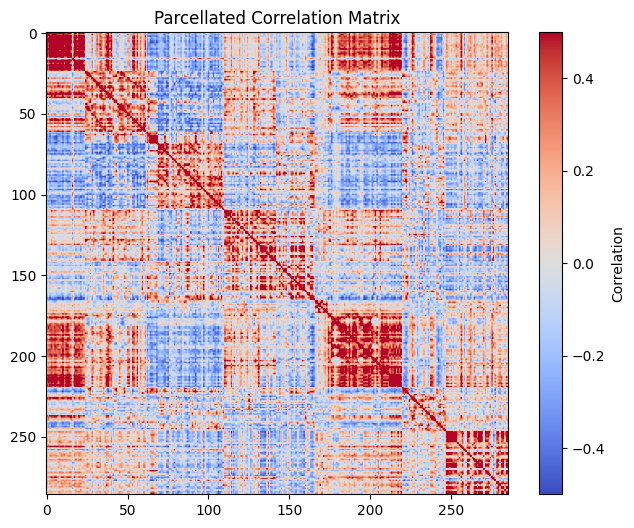

In [35]:
ptseries_ordered = ptseries_data[:, parcel_order]
ptseries_ordered = ptseries_ordered[:, keepnets]
ptseries_masked = np.transpose(ptseries_ordered[tmask])

corrs_parcel = np.corrcoef(ptseries_masked)
print(corrs_parcel.shape)

plt.figure(figsize=(8, 6))
plt.imshow(corrs_parcel, cmap='coolwarm', vmin=-0.5, vmax=0.5)
plt.colorbar(label='Correlation')
plt.title('Parcellated Correlation Matrix')
plt.show()

In [16]:
# dtseries_img = nib.load(dtseries_path)
# dtseries_data = dtseries_img.get_fdata()
# bm_index_map = dtseries_img.header.get_index_map(1)

# # Initialize storage
# vertex_indices = []
# # Loop through the brain models in the index map
# for bm in bm_index_map.brain_models:
#     structure = bm.brain_structure
#     if structure in ['CIFTI_STRUCTURE_CORTEX_LEFT', 'CIFTI_STRUCTURE_CORTEX_RIGHT']:
#         # Convert Cifti2VertexIndices to numpy array
#         offset = bm.index_offset
#         count = bm.index_count
#         vertex_indices.extend(range(offset, offset + count))

# vertex_indices = np.array(vertex_indices)
# cortex_dtseries = np.transpose(dtseries_data[:, vertex_indices])
# masked_cortex_dtseries = cortex_dtseries[:, tmask]

# print(masked_cortex_dtseries.shape)

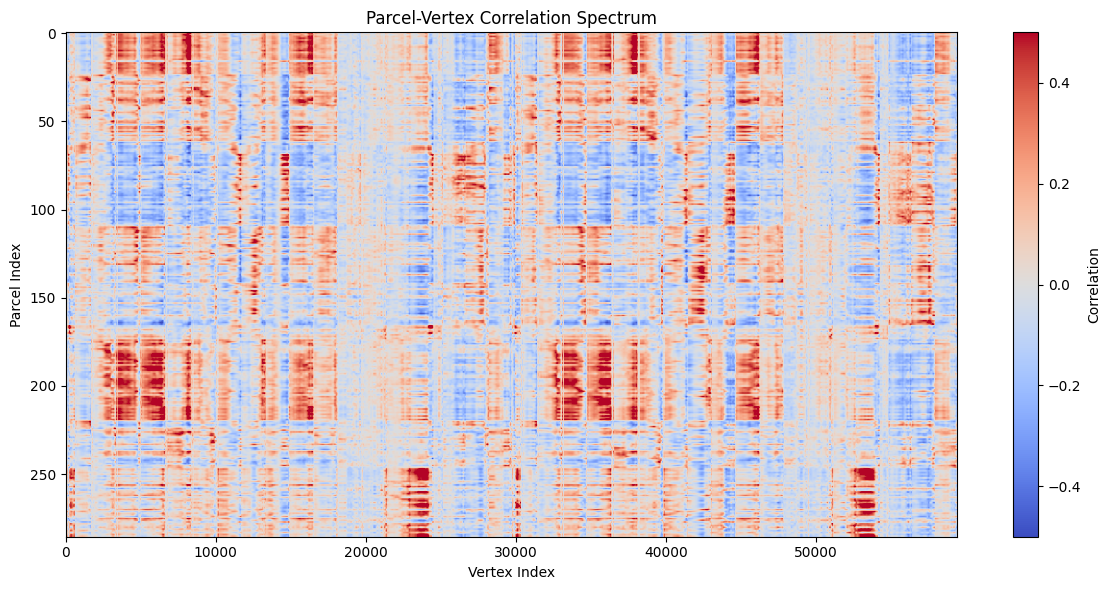

In [34]:
# full_corr_matrix = np.corrcoef(np.vstack([ptseries_masked, masked_cortex_dtseries]))
# num_parcels = ptseries_masked.shape[0]
# parcel_vertex_corr_matrix = full_corr_matrix[:num_parcels, num_parcels:]

# print(parcel_vertex_corr_matrix.shape)

parcel_vertex_corr_matrix = calc_parcel_vertex_correlations(dtseries_path, ptseries_path, tmask, parcellation)

plt.figure(figsize=(12, 6))
plt.imshow(parcel_vertex_corr_matrix, aspect='auto', cmap='coolwarm', vmin=-0.5, vmax=0.5)
plt.colorbar(label='Correlation')
plt.xlabel('Vertex Index')
plt.ylabel('Parcel Index')
plt.title('Parcel-Vertex Correlation Spectrum')
plt.tight_layout()
plt.show()

In [18]:
# left_mask_struct = sio.loadmat(os.path.join(transmat_path, "Left_fMRI2Grid_192_by_192_NN.mat"))
# left_mask = left_mask_struct['grid_mapping']
# right_mask_struct = sio.loadmat(os.path.join(transmat_path, "Right_fMRI2Grid_192_by_192_NN.mat"))
# right_mask = right_mask_struct['grid_mapping']
# print(left_mask.shape)
# print(right_mask.shape)
# mask = sio.loadmat(os.path.join(transmat_path, "MSE_Mask.mat"))

In [19]:
# for test
# corrs = calc_correlations(input_file=dtseries_path, tmask=tmask)
# corrs = rand_sample(corrs, sample_ratio=0.1)
# left_surf_data, right_surf_data = forward_reformatting(corrs, transmat_path, img_size=192)
# print(left_surf_data.shape)
# print(right_surf_data.shape)
print(parcel_vertex_corr_matrix.shape)
left_surf_data, right_surf_data = forward_reformatting(parcel_vertex_corr_matrix, transmat_path, img_size=192)
print(left_surf_data.shape)

(286, 59412)
(286, 1, 192, 192)


In [32]:
model = load_model(zdim=2, nc=1, device="cpu")
zs, left_surf_recon, right_surf_recon = model_inference(left_surf_data, right_surf_data, zdim=2, nc=1, mode="both", batch_size=16, device="cpu")
mus = zs[:, :2]

print(mus.shape)
print(left_surf_recon.shape)
print(right_surf_recon.shape)

(286, 2)
(286, 1, 192, 192)
(286, 1, 192, 192)


In [29]:
parcel_labels = parcel_keys[keepnets, 1].flatten() - 1
print(net_names)

[array(['Aud'], dtype='<U3') array(['CON'], dtype='<U3')
 array(['PMN'], dtype='<U3') array(['DMN'], dtype='<U3')
 array(['DAN'], dtype='<U3') array(['FPN'], dtype='<U3')
 array(['None'], dtype='<U4') array(['RTN'], dtype='<U3')
 array(['SMN hand'], dtype='<U8') array(['SMN mouth'], dtype='<U9')
 array(['Sal'], dtype='<U3') array(['VAN'], dtype='<U3')
 array(['Vis'], dtype='<U3')]


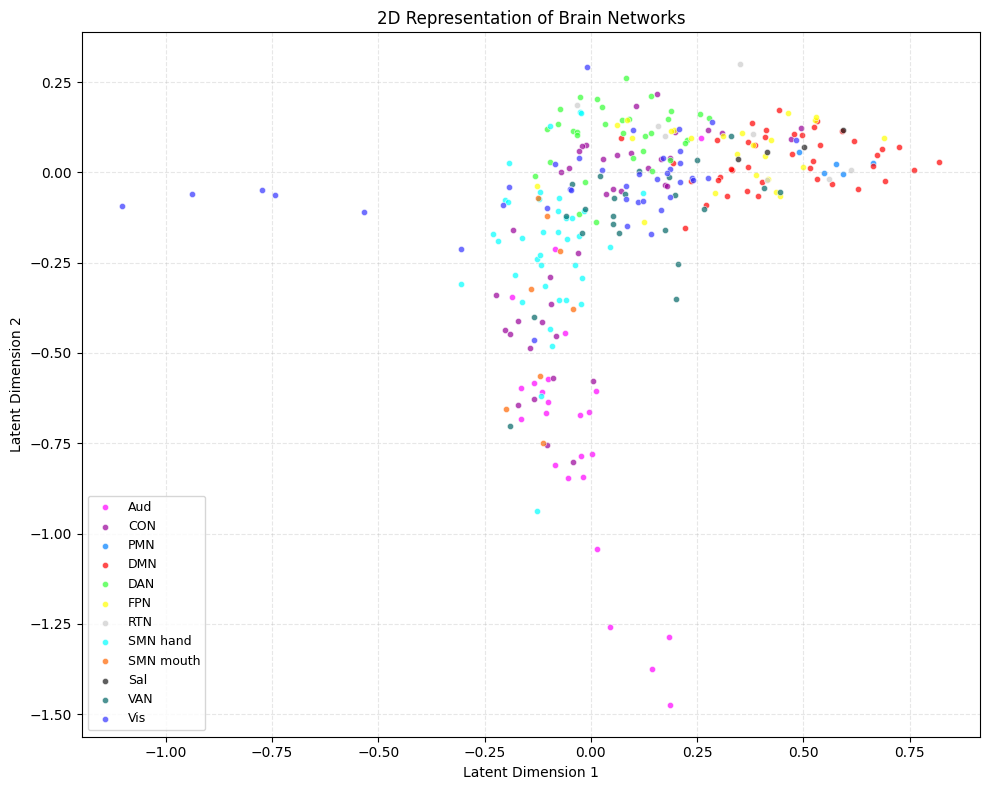

In [33]:
visualize_representations(mus, parcel_labels, net_names, net_colors)